Various sources used for understanding random forest models and grid search:
* https://builtin.com/data-science/random-forest-python
* https://medium.com/@hammad.ai/using-grid-search-for-hyper-parameter-tuning-bad6756324cc
* https://towardsdatascience.com/cross-validation-and-grid-search-efa64b127c1b/





### Approach 1 - Removing US-produced movies and shows

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('https://raw.githubusercontent.com/cacress/CSC442/refs/heads/main/datasets/modified_v2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7688 entries, 0 to 7687
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            7688 non-null   object 
 1   type                             7688 non-null   object 
 2   release_year                     7688 non-null   int64  
 3   age_certification                4685 non-null   object 
 4   runtime                          7688 non-null   int64  
 5   genres                           7688 non-null   object 
 6   production_countries             7688 non-null   object 
 7   seasons                          3166 non-null   float64
 8   imdb_score                       7234 non-null   float64
 9   imdb_votes                       7219 non-null   float64
 10  tmdb_popularity                  7688 non-null   float64
 11  normalized_tmdb_score            7483 non-null   float64
 12  top_genres          

In [ ]:
# For my data query, I am focusing on non-US produced movies/shows
# Note, this may change if my model could use more data points
df = df[df['production_countries'].str.contains('US') == False]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3906 entries, 0 to 3905
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            3906 non-null   object 
 1   type                             3906 non-null   object 
 2   release_year                     3906 non-null   int64  
 3   age_certification                1973 non-null   object 
 4   runtime                          3906 non-null   int64  
 5   genres                           3906 non-null   object 
 6   production_countries             3906 non-null   object 
 7   seasons                          1620 non-null   float64
 8   imdb_score                       3663 non-null   float64
 9   imdb_votes                       3658 non-null   float64
 10  tmdb_popularity                  3906 non-null   float64
 11  normalized_tmdb_score            3773 non-null   float64
 12  top_genres          

Since there are so many unique values for production_countries,
I need to find a way to categorize it -- one hot encoding for each country
may not be the best b/c there are A LOT of other countries (105, if I remember correctly).

Some categorization ideas:
- One-hot encoding for top N-producing countries (e.g., having binary variables for the India, Japan, Great Britain if N = 3)
- Same as above, but with an Other variable, which lumps all non-mentioned countries
- One-hot encoding for top N-producing countries in each continent region (e.g., Great Britain, Spain, France in Europe if N = 3)
- Same as above, but with Other variable for each world region

**I'll probably start with idea 4**

In [ ]:
# Fixing the observations with unknown ('XX') production countries
# Fetch the observations with XX for production countries
drop_indices = df[df['production_countries'].str.contains('XX') == True].index
unknown_df = df[df['production_countries'].str.contains('XX') == True]
df = df.drop(drop_indices)
unknown_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 328 to 3028
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            27 non-null     object 
 1   type                             27 non-null     object 
 2   release_year                     27 non-null     int64  
 3   age_certification                9 non-null      object 
 4   runtime                          27 non-null     int64  
 5   genres                           27 non-null     object 
 6   production_countries             27 non-null     object 
 7   seasons                          5 non-null      float64
 8   imdb_score                       26 non-null     float64
 9   imdb_votes                       26 non-null     float64
 10  tmdb_popularity                  27 non-null     float64
 11  normalized_tmdb_score            23 non-null     float64
 12  top_genres               

In [ ]:
unknown_df.head(27)

title   type  release_year  \
328                                 Ancient Top 10   SHOW          2016   
430                                      Hillbilly  MOVIE          2018   
434                                        Get Big  MOVIE          2017   
437                               The Cat Rescuers  MOVIE          2018   
438                      Blue Exorcist: Kyoto Saga   SHOW          2017   
635                                     Team Marco  MOVIE          2019   
677                     Celebrity Wheel of Fortune   SHOW          2021   
1081        Chhota Bheem In Dholakpur to Kathmandu  MOVIE          2012   
1210                           Wedding Association  MOVIE          2013   
1219           Chhota Bheem in the Incan Adventure  MOVIE          2013   
1227             Romantik Komedi 2: Bekarlığa Veda  MOVIE          2013   
1374             Kathleen Madigan: Bothering Jesus  MOVIE          2016   
1496  The Massively Mixed-Up Middle School Mystery  MOVIE          2015   
1811                  Tig Notaro: Happy To Be Here  MOVIE          2018   
2007                                    F.R.E.D.I.  MOVIE          2018   
2120       Rodney Carrington: Here Comes the Truth  MOVIE          2017   
2139                               Marriage Palace  MOVIE          2018   
2165                   Tracy Morgan: Staying Alive  MOVIE          2017   
2214                        Three Words to Forever  MOVIE          2018   
2226                                  Project Papa  MOVIE          2018   
2252                    Fakkah Fuzz: Almost Banned  MOVIE          2018   
2259                                    Next Enti?  MOVIE          2018   
2274                              Grillo vs Grillo  MOVIE          2017   
2283              Kavin Jay : Everybody Calm Down!  MOVIE          2018   
2667                           Beyblade Burst Rise   SHOW          2019   
2787          Octonauts and the Great Barrier Reef  MOVIE          2020   
3028                   Bad Boy Billionaires: India   SHOW          2020   

     age_certification  runtime  \
328              TV-14       40   
430                NaN       87   
434                NaN       85   
437                NaN       87   
438              TV-14       24   
635                NaN       92   
677              TV-PG       38   
1081                 G       70   
1210             PG-13      106   
1219                 G       64   
1227               NaN      105   
1374                 R       71   
1496               NaN       39   
1811               NaN       58   
2007               NaN       89   
2120               NaN       66   
2139               NaN      102   
2165               NaN       60   
2214               NaN      106   
2226                 G       97   
2252               NaN       60   
2259               NaN      157   
2274               NaN       95   
2283               NaN       53   
2667               NaN       23   
2787               NaN       47   
3028             TV-14       59   

                                                 genres production_countries  \
328                        ['documentation', 'history']               ['XX']   
430             ['documentation', 'horror', 'thriller']               ['XX']   
434                                 ['comedy', 'drama']               ['XX']   
437                                   ['documentation']               ['XX']   
438   ['action', 'animation', 'drama', 'family', 'fa...               ['XX']   
635                       ['comedy', 'drama', 'family']               ['XX']   
677                                          ['family']               ['XX']   
1081                                      ['animation']               ['XX']   
1210                                         ['comedy']               ['XX']   
1219                           ['animation', 'fantasy']               ['XX']   
1227                              ['comedy', 'romance']               ['XX']   
137

In [ ]:
# From additional research, the following have the US as a production country, so we can just remove them
unknown_df = unknown_df.drop([430, 434, 437, 635, 677, 1374, 1496, 1811, 2007, 2120, 2165])
print("Length is now: ", unknown_df.shape[0])

# The following were produced in the UK or Great Britain (GB)
unknown_df.loc[unknown_df['title'] == 'Ancient Top 10', 'production_countries'] = "['GB']"
unknown_df.loc[unknown_df['title'] == 'Octonauts and the Great Barrier Reef', 'production_countries'] = "['GB']"

# The following were produced in Japan (JP)
unknown_df.loc[unknown_df['title'] == 'Blue Exorcist: Kyoto Saga', 'production_countries'] = "['JP']"
unknown_df.loc[unknown_df['title'] == 'Beyblade Burst Rise', 'production_countries'] = "['JP']"

# The following were produced in India (IN)
unknown_df.loc[unknown_df['title'] == 'Chhota Bheem In Dholakpur to Kathmandu', 'production_countries'] = "['IN']"
unknown_df.loc[unknown_df['title'] == 'Chhota Bheem in the Incan Adventure', 'production_countries'] = "['IN']"
unknown_df.loc[unknown_df['title'] == 'Marriage Palace', 'production_countries'] = "['IN']"
unknown_df.loc[unknown_df['title'] == 'Project Papa', 'production_countries'] = "['IN']"
unknown_df.loc[unknown_df['title'] == 'Next Enti?', 'production_countries'] = "['IN']"
unknown_df.loc[unknown_df['title'] == 'Bad Boy Billionaires: India', 'production_countries'] = "['IN']"

# Everything else
unknown_df.loc[unknown_df['title'] == 'Romantik Komedi 2: Bekarlığa Veda', 'production_countries'] = "['TR']"
unknown_df.loc[unknown_df['title'] == 'Wedding Association', 'production_countries'] = "['TR']"
unknown_df.loc[unknown_df['title'] == 'Three Words to Forever', 'production_countries'] = "['PH']"
unknown_df.loc[unknown_df['title'] == 'Fakkah Fuzz: Almost Banned', 'production_countries'] = "['SG']"
unknown_df.loc[unknown_df['title'] == 'Grillo vs Grillo', 'production_countries'] = "['IT']"
unknown_df.loc[unknown_df['title'] == 'Kavin Jay : Everybody Calm Down!', 'production_countries'] = "['MY']"

unknown_df.head(16)

Length is now:  16


title   type  release_year  \
328                           Ancient Top 10   SHOW          2016   
438                Blue Exorcist: Kyoto Saga   SHOW          2017   
1081  Chhota Bheem In Dholakpur to Kathmandu  MOVIE          2012   
1210                     Wedding Association  MOVIE          2013   
1219     Chhota Bheem in the Incan Adventure  MOVIE          2013   
1227       Romantik Komedi 2: Bekarlığa Veda  MOVIE          2013   
2139                         Marriage Palace  MOVIE          2018   
2214                  Three Words to Forever  MOVIE          2018   
2226                            Project Papa  MOVIE          2018   
2252              Fakkah Fuzz: Almost Banned  MOVIE          2018   
2259                              Next Enti?  MOVIE          2018   
2274                        Grillo vs Grillo  MOVIE          2017   
2283        Kavin Jay : Everybody Calm Down!  MOVIE          2018   
2667                     Beyblade Burst Rise   SHOW          2019   
2787    Octonauts and the Great Barrier Reef  MOVIE          2020   
3028             Bad Boy Billionaires: India   SHOW          2020   

     age_certification  runtime  \
328              TV-14       40   
438              TV-14       24   
1081                 G       70   
1210             PG-13      106   
1219                 G       64   
1227               NaN      105   
2139               NaN      102   
2214               NaN      106   
2226                 G       97   
2252               NaN       60   
2259               NaN      157   
2274               NaN       95   
2283               NaN       53   
2667               NaN       23   
2787               NaN       47   
3028             TV-14       59   

                                                 genres production_countries  \
328                        ['documentation', 'history']               ['GB']   
438   ['action', 'animation', 'drama', 'family', 'fa...               ['JP']   
1081                                      ['animation']               ['IN']   
1210                                         ['comedy']               ['TR']   
1219                           ['animation', 'fantasy']               ['IN']   
1227                              ['comedy', 'romance']               ['TR']   
2139                                         ['comedy']               ['IN']   
2214           ['comedy', 'drama', 'family', 'romance']               ['PH']   
2226                                          ['drama']               ['IN']   
2252                                         ['comedy']               ['SG']   
2259                     ['comedy', 'drama', 'romance']               ['IN']   
2274                             ['comedy', 'european']               ['IT']   
2283                        ['comedy', 'documentation']               ['MY']   
2667  ['action', 'animation', 'fantasy', 'scifi', 's...               ['JP']   
2787        ['action', 'animation', 'comedy', 'family']               ['GB']   
3028                         ['crime', 'documentation']               ['IN']   

      seasons  imdb_score  imdb_votes  tmdb_popularity  normalized_tmdb_score  \
328       1.0         7.6        92.0         1.918000                   8.47   
438       1.0         7.4      2342.0         0.272976                   7.30   
1081      NaN         7.9        50.0         1.172000                   7.30   
1210      NaN         7.0     22458.0         4.209000                   6.67   
1219      NaN         7.5        32.0         2.038000                    NaN   
1227      NaN         5.1      3383.0         4.536000                   5.59   
2139      NaN         6.2       184.0         0.840000                   7.30   
2214      NaN         6.8       110.0         2.040000                  10.00   
2226      NaN         6.3        35.0         1.433000                    NaN   
2252      NaN         4.2        57.0         1.806000                   5.05   
2259      NaN    

In [ ]:
# We can now add these back to the original dataframe
df = pd.concat([df, unknown_df])
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895 entries, 0 to 3894
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            3895 non-null   object 
 1   type                             3895 non-null   object 
 2   release_year                     3895 non-null   int64  
 3   age_certification                1971 non-null   object 
 4   runtime                          3895 non-null   int64  
 5   genres                           3895 non-null   object 
 6   production_countries             3895 non-null   object 
 7   seasons                          1619 non-null   float64
 8   imdb_score                       3653 non-null   float64
 9   imdb_votes                       3648 non-null   float64
 10  tmdb_popularity                  3895 non-null   float64
 11  normalized_tmdb_score            3763 non-null   float64
 12  top_genres          

In [ ]:
# Let me recall what were the top producing countries
# This code is from my EDA notebook

import ast

# Get the unique country codes (singular, not the full list)
# And compute their frequency
unique_codes_dict = {}
for i in range(len(df)):
    obs = df.loc[i, 'production_countries']
    # Convert to a list
    string = ast.literal_eval(obs)
    for code in string:
      # If unique, add it to the dictionary, otherwise, increment the existing key/value pair
      if code not in unique_codes_dict:
        unique_codes_dict[code] = 1;
      else:
        unique_codes_dict[code] += 1;

# Create dictionary by frequency value (most to least)
frequency_dict = dict(sorted(unique_codes_dict.items(), key=lambda x: x[1], reverse=True))

# Output the top N countries that have appeared in movies/shows
N = 40
freq_list = list(frequency_dict.items())
top_countries = list(frequency_dict.keys())[:N]
for i in range(N):
  print(freq_list[i])

('IN', 607)
('JP', 542)
('GB', 440)
('FR', 257)
('KR', 237)
('CA', 205)
('ES', 205)
('DE', 142)
('MX', 126)
('AU', 103)
('BR', 99)
('TR', 86)
('PH', 85)
('IT', 84)
('CN', 84)
('BE', 70)
('AR', 69)
('TW', 61)
('ID', 58)
('NG', 58)
('EG', 47)
('SE', 46)
('CO', 45)
('ZA', 44)
('PL', 44)
('DK', 39)
('NL', 36)
('HK', 36)
('LB', 35)
('TH', 34)
('NO', 34)
('IE', 22)
('CL', 18)
('SG', 18)
('PS', 17)
('MY', 17)
('RU', 16)
('NZ', 15)
('IL', 14)
('AE', 14)


In [ ]:
# Create new binary variable india_prod that is 1 if 'IN' is contained in production_countries, otherwise 0
df['india_prod'] = np.where(df['production_countries'].str.contains('IN'), 1, 0)

# Do the same for the other top countries with the most productions
df['japan_prod'] = np.where(df['production_countries'].str.contains('JP'), 1, 0)
df['great_britain_prod'] = np.where(df['production_countries'].str.contains('GB'), 1, 0)
df['france_prod'] = np.where(df['production_countries'].str.contains('FR'), 1, 0)
df['korea_prod'] = np.where(df['production_countries'].str.contains('KR'), 1, 0)
df['canada_prod'] = np.where(df['production_countries'].str.contains('CA'), 1, 0)
df['spain_prod'] = np.where(df['production_countries'].str.contains('ES'), 1, 0)
df['germany_prod'] = np.where(df['production_countries'].str.contains('DE'), 1, 0)
df['mexico_prod'] = np.where(df['production_countries'].str.contains('MX'), 1, 0)
df['australia_prod'] = np.where(df['production_countries'].str.contains('AU'), 1, 0)
df['brazil_prod'] = np.where(df['production_countries'].str.contains('BR'), 1, 0)
df['turkey_prod'] = np.where(df['production_countries'].str.contains('TR'), 1, 0)
df['phillipines_prod'] = np.where(df['production_countries'].str.contains('PH'), 1, 0)
df['italy_prod'] = np.where(df['production_countries'].str.contains('IT'), 1, 0)
df['china_prod'] = np.where(df['production_countries'].str.contains('CN'), 1, 0)
df['belgium_prod'] = np.where(df['production_countries'].str.contains('BE'), 1, 0)
df['argentina_prod'] = np.where(df['production_countries'].str.contains('AR'), 1, 0)
df['taiwan_prod'] = np.where(df['production_countries'].str.contains('TW'), 1, 0)
df['indonesia_prod'] = np.where(df['production_countries'].str.contains('ID'), 1, 0)
df['nigeria_prod'] = np.where(df['production_countries'].str.contains('NG'), 1, 0)
df['egypt_prod'] = np.where(df['production_countries'].str.contains('EG'), 1, 0)
df['sweden_prod'] = np.where(df['production_countries'].str.contains('SE'), 1, 0)
df['colombia_prod'] = np.where(df['production_countries'].str.contains('CO'), 1, 0)
df['south_africa_prod'] = np.where(df['production_countries'].str.contains('ZA'), 1, 0)
df['poland_prod'] = np.where(df['production_countries'].str.contains('PL'), 1, 0)
df['denmark_prod'] = np.where(df['production_countries'].str.contains('DK'), 1, 0)
df['netherlands_prod'] = np.where(df['production_countries'].str.contains('NL'), 1, 0)
df['hong_kong_prod'] = np.where(df['production_countries'].str.contains('HK'), 1, 0)
df['lebanon_prod'] = np.where(df['production_countries'].str.contains('LB'), 1, 0)
df['thailand_prod'] = np.where(df['production_countries'].str.contains('TH'), 1, 0)
df['norway_prod'] = np.where(df['production_countries'].str.contains('NO'), 1, 0)
df['ireland_prod'] = np.where(df['production_countries'].str.contains('IE'), 1, 0)
df['chile_prod'] = np.where(df['production_countries'].str.contains('CL'), 1, 0)
df['singapore_prod'] = np.where(df['production_countries'].str.contains('SG'), 1, 0)
df['palestine_prod'] = np.where(df['production_countries'].str.contains('PS'), 1, 0)
df['malaysia_prod'] = np.where(df['production_countries'].str.contains('MY'), 1, 0)
df['russia_prod'] = np.where(df['production_countries'].str.contains('RU'), 1, 0)
df['new_zealand_prod'] = np.where(df['production_countries'].str.contains('NZ'), 1, 0)
df['israel_prod'] = np.where(df['production_countries'].str.contains('IL'), 1, 0)
df['united_arab_emirates_prod'] = np.where(df['production_countries'].str.contains('AE'), 1, 0)

# Other category for any country not in top_countries
df['other_prod'] = 0
for i in range(len(df)):
  temp_list = ast.literal_eval(df.loc[i, 'production_countries'])
  for value in temp_list:
    if value not in top_countries:
      df.loc[i, 'other_prod'] = 1
      break

In [ ]:
# Remove any observations with na imdb_votes
df = df.dropna(subset=['imdb_votes'])
df.reset_index(drop=True, inplace=True)

# Apply log to imdb_votes to minimize effect of outliers
df['log_imdb_votes'] = df.loc[:,'imdb_votes'].apply(lambda x: np.log(x))

# Replace na seasons with 0
df['seasons'] = df.loc[:, 'seasons'].apply(lambda x: 0 if np.isnan(x) else x)

# Get dummy variables for type
df = pd.get_dummies(df, columns=['type'])
df['type_MOVIE'] = df['type_MOVIE'].astype(int)
df['type_SHOW'] = df['type_SHOW'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3648 entries, 0 to 3647
Data columns (total 63 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            3648 non-null   object 
 1   release_year                     3648 non-null   int64  
 2   age_certification                1878 non-null   object 
 3   runtime                          3648 non-null   int64  
 4   genres                           3648 non-null   object 
 5   production_countries             3648 non-null   object 
 6   seasons                          3648 non-null   float64
 7   imdb_score                       3648 non-null   float64
 8   imdb_votes                       3648 non-null   float64
 9   tmdb_popularity                  3648 non-null   float64
 10  normalized_tmdb_score            3516 non-null   float64
 11  top_genres                       3648 non-null   object 
 12  genres_count        

<ipython-input-53-7cef50458cbf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_imdb_votes'] = df.loc[:,'imdb_votes'].apply(lambda x: np.log(x))
<ipython-input-53-7cef50458cbf>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seasons'] = df.loc[:, 'seasons'].apply(lambda x: 0 if np.isnan(x) else x)


In [ ]:
pd.set_option('display.max_columns', None)
df.head(2)

title  release_year age_certification  runtime  \
0        Akira          1988                 R      124   
1  Dragon Ball          1986             TV-14       24   

                                              genres production_countries  \
0  ['action', 'animation', 'drama', 'fantasy', 's...               ['JP']   
1  ['action', 'animation', 'comedy', 'fantasy', '...               ['JP']   

   seasons  imdb_score  imdb_votes  tmdb_popularity  normalized_tmdb_score  \
0      0.0         8.0    181098.0           45.959                   8.20   
1     10.0         8.6     55153.0           16.956                   8.38   

              top_genres  genres_count  production_countries_count  \
0    ['action', 'scifi']           6.0                         1.0   
1  ['scifi', 'thriller']           6.0                         1.0   

   average_score  score_difference  genres_uniqueness  \
0           8.10             -0.20           0.759921   
1           8.49              0.22           0.755724   

   production_countries_uniqueness  title_uniqueness_norm  india_prod  \
0                         0.927648               0.822959           0   
1                         0.927648               0.746032           0   

   japan_prod  great_britain_prod  france_prod  korea_prod  canada_prod  \
0           1                   0            0           0            0   
1           1                   0            0           0            0   

   spain_prod  germany_prod  mexico_prod  australia_prod  brazil_prod  \
0           0             0            0               0            0   
1           0             0            0               0            0   

   turkey_prod  phillipines_prod  italy_prod  china_prod  belgium_prod  \
0            0                 0           0           0             0   
1            0                 0           0           0             0   

   argentina_prod  taiwan_prod  indonesia_prod  nigeria_prod  egypt_prod  \
0               0            0               0             0           0   
1               0            0               0             0           0   

   sweden_prod  colombia_prod  south_africa_prod  poland_prod  denmark_prod  \
0            0              0                  0            0             0   
1            0              0                  0            0             0   

   netherlands_prod  hong_kong_prod  lebanon_prod  thailand_prod  norway_prod  \
0                 0               0             0              0            0   
1                 0               0             0              0            0   

   ireland_prod  chile_prod  singapore_prod  palestine_prod  malaysia_prod  \
0             0           0               0               0              0   
1             0           0               0               0              0   

   russia_prod  new_zealand_prod  israel_prod  united_arab_emirates_prod  \
0            0                 0            0                          0   
1            0                 0            0                          0   

   other_prod  log_imdb_votes  type_MOVIE  type_SHOW  
0           0       12.106794           1          0  
1           0       10.917866           0          1

In [ ]:
# Let sqrt_imdb_votes be the response variable
y = df['log_imdb_votes']

# Selecting predictor variables
col_indices = [1, 6, 13, df.shape[1]-2, df.shape[1]-1] + list(range(19, df.shape[1]-3))
X = df.iloc[:, col_indices]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3648 entries, 0 to 3647
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   release_year                3648 non-null   int64  
 1   seasons                     3648 non-null   float64
 2   production_countries_count  3648 non-null   float64
 3   type_MOVIE                  3648 non-null   int64  
 4   type_SHOW                   3648 non-null   int64  
 5   india_prod                  3648 non-null   int64  
 6   japan_prod                  3648 non-null   int64  
 7   great_britain_prod          3648 non-null   int64  
 8   france_prod                 3648 non-null   int64  
 9   korea_prod                  3648 non-null   int64  
 10  canada_prod                 3648 non-null   int64  
 11  spain_prod                  3648 non-null   int64  
 12  germany_prod                3648 non-null   int64  
 13  mexico_prod                 3648 

In [ ]:
# Checking these are the same size
print(X.shape[0])
print(y.shape[0])

3648
3648


In [ ]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=31)

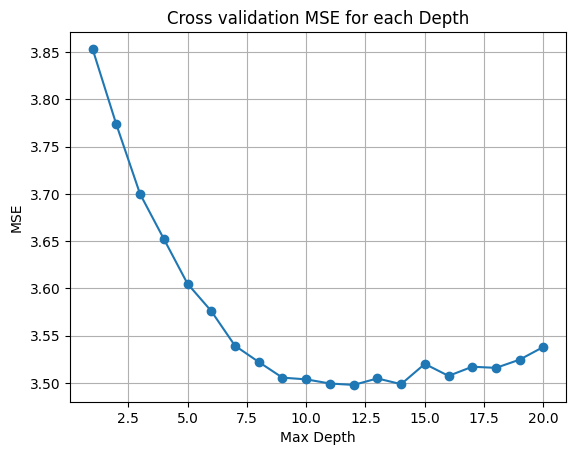

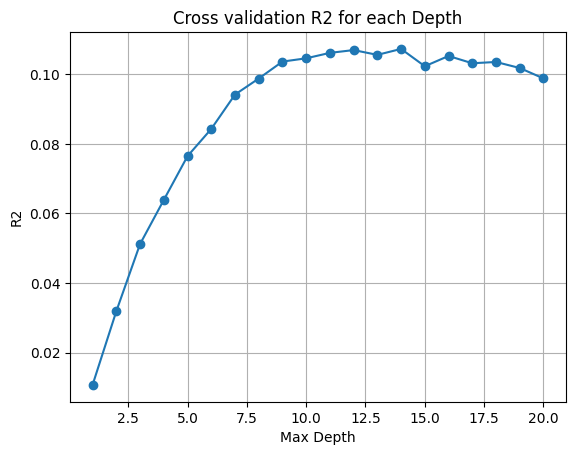

In [ ]:
# Determine what the max depth should be based
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

depths = range(1, 21)
mse_scores = []
r2_scores = []

for depth in depths:
    # Determine MSE for each depth
    model = RandomForestRegressor(max_depth=depth, n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', random_state=31)
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores.append(-scores.mean())
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    r2_scores.append(scores.mean())

plt.figure()
plt.plot(depths, mse_scores, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.title('Cross validation MSE for each Depth')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(depths, r2_scores, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('R2')
plt.title('Cross validation R2 for each Depth')
plt.grid(True)
plt.show()

In [ ]:
# Determine optimal parameters

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

param_grid = {
    'max_depth': [10],
    'n_estimators': [100, 200],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5],
    'random_state': [31],
    'max_features': ['sqrt']
}

grid = GridSearchCV(RandomForestRegressor(random_state=31), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best R2 score:", grid.best_score_)
print("Test R2:", grid.score(X_test, y_test))

grid2 = GridSearchCV(RandomForestRegressor(random_state=31), param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid2.fit(X_train, y_train)
print("Best RMSE score:", -grid2.best_score_)
print("Test RMSE:", -grid2.score(X_test, y_test))

Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 31}
Best R2 score: 0.15563491864423826
Test R2: 0.1967585740898492
Best RMSE score: 1.8319506146379017
Test RMSE: 1.7205071889698333


In [ ]:
# Plot one of the decision trees
from sklearn import tree

fn=X.columns.to_list()
cn=y
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,10), dpi=800)
tree.plot_tree(grid.best_estimator_.estimators_[2],
               feature_names = fn,
               class_names=cn,
               filled = True);

In [ ]:
# Feature importance
from sklearn.inspection import permutation_importance

model = RandomForestRegressor(max_depth=10, n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', random_state=31)
model.fit(X_train, y_train)

importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=31)

In [ ]:
feature_names = X_train.columns

perm_df = pd.DataFrame({'feature': feature_names, 'importance': importance.importances_mean})
perm_df = perm_df.sort_values('importance', ascending=False)

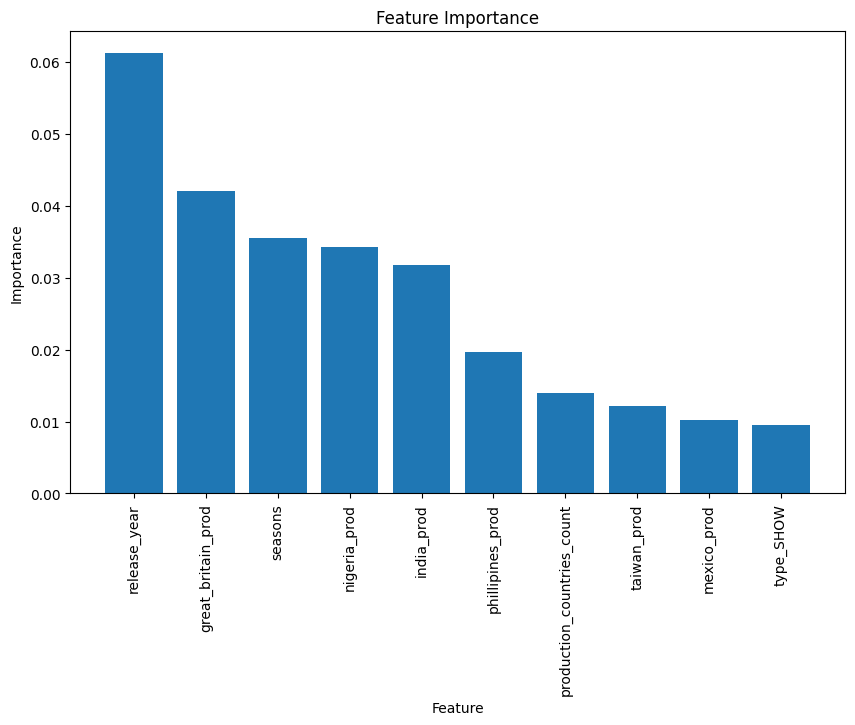

In [ ]:
# Print the top 10 important features
plt.figure(figsize=(10, 6))
plt.bar(perm_df.head(10)['feature'], perm_df.head(10)['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

### Approach 2 - Keeping US-produced countries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('https://raw.githubusercontent.com/cacress/CSC442/refs/heads/main/datasets/modified_v2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7688 entries, 0 to 7687
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            7688 non-null   object 
 1   type                             7688 non-null   object 
 2   release_year                     7688 non-null   int64  
 3   age_certification                4685 non-null   object 
 4   runtime                          7688 non-null   int64  
 5   genres                           7688 non-null   object 
 6   production_countries             7688 non-null   object 
 7   seasons                          3166 non-null   float64
 8   imdb_score                       7234 non-null   float64
 9   imdb_votes                       7219 non-null   float64
 10  tmdb_popularity                  7688 non-null   float64
 11  normalized_tmdb_score            7483 non-null   float64
 12  top_genres          

In [ ]:
# Fixing the observations with unknown ('XX') production countries
# Fetch the observations with XX for production countries
drop_indices = df[df['production_countries'].str.contains('XX') == True].index
unknown_df = df[df['production_countries'].str.contains('XX') == True]
df = df.drop(drop_indices)
unknown_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 1061 to 6347
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            27 non-null     object 
 1   type                             27 non-null     object 
 2   release_year                     27 non-null     int64  
 3   age_certification                9 non-null      object 
 4   runtime                          27 non-null     int64  
 5   genres                           27 non-null     object 
 6   production_countries             27 non-null     object 
 7   seasons                          5 non-null      float64
 8   imdb_score                       26 non-null     float64
 9   imdb_votes                       26 non-null     float64
 10  tmdb_popularity                  27 non-null     float64
 11  normalized_tmdb_score            23 non-null     float64
 12  top_genres              

In [ ]:
# The following were produced in the UK or Great Britain (GB)
unknown_df.loc[unknown_df['title'] == 'Ancient Top 10', 'production_countries'] = "['GB']"
unknown_df.loc[unknown_df['title'] == 'Octonauts and the Great Barrier Reef', 'production_countries'] = "['GB']"

# The following were produced in Japan (JP)
unknown_df.loc[unknown_df['title'] == 'Blue Exorcist: Kyoto Saga', 'production_countries'] = "['JP']"
unknown_df.loc[unknown_df['title'] == 'Beyblade Burst Rise', 'production_countries'] = "['JP']"

# The following were produced in India (IN)
unknown_df.loc[unknown_df['title'] == 'Chhota Bheem In Dholakpur to Kathmandu', 'production_countries'] = "['IN']"
unknown_df.loc[unknown_df['title'] == 'Chhota Bheem in the Incan Adventure', 'production_countries'] = "['IN']"
unknown_df.loc[unknown_df['title'] == 'Marriage Palace', 'production_countries'] = "['IN']"
unknown_df.loc[unknown_df['title'] == 'Project Papa', 'production_countries'] = "['IN']"
unknown_df.loc[unknown_df['title'] == 'Next Enti?', 'production_countries'] = "['IN']"
unknown_df.loc[unknown_df['title'] == 'Bad Boy Billionaires: India', 'production_countries'] = "['IN']"

# Others
unknown_df.loc[unknown_df['title'] == 'Romantik Komedi 2: Bekarlığa Veda', 'production_countries'] = "['TR']"
unknown_df.loc[unknown_df['title'] == 'Wedding Association', 'production_countries'] = "['TR']"
unknown_df.loc[unknown_df['title'] == 'Three Words to Forever', 'production_countries'] = "['PH']"
unknown_df.loc[unknown_df['title'] == 'Fakkah Fuzz: Almost Banned', 'production_countries'] = "['SG']"
unknown_df.loc[unknown_df['title'] == 'Grillo vs Grillo', 'production_countries'] = "['IT']"
unknown_df.loc[unknown_df['title'] == 'Kavin Jay : Everybody Calm Down!', 'production_countries'] = "['MY']"

# The rest are produced in the US
unknown_df.loc[unknown_df['production_countries'].str.contains('XX') == True, 'production_countries'] = "['US']"
unknown_df.head(27)

title   type  release_year  \
1061                                Ancient Top 10   SHOW          2016   
1360                                     Hillbilly  MOVIE          2018   
1374                                       Get Big  MOVIE          2017   
1382                              The Cat Rescuers  MOVIE          2018   
1383                     Blue Exorcist: Kyoto Saga   SHOW          2017   
1927                                    Team Marco  MOVIE          2019   
2118                    Celebrity Wheel of Fortune   SHOW          2021   
2905        Chhota Bheem In Dholakpur to Kathmandu  MOVIE          2012   
3147                           Wedding Association  MOVIE          2013   
3159           Chhota Bheem in the Incan Adventure  MOVIE          2013   
3168             Romantik Komedi 2: Bekarlığa Veda  MOVIE          2013   
3500             Kathleen Madigan: Bothering Jesus  MOVIE          2016   
3680  The Massively Mixed-Up Middle School Mystery  MOVIE          2015   
4342                  Tig Notaro: Happy To Be Here  MOVIE          2018   
4646                                    F.R.E.D.I.  MOVIE          2018   
4822       Rodney Carrington: Here Comes the Truth  MOVIE          2017   
4849                               Marriage Palace  MOVIE          2018   
4880                   Tracy Morgan: Staying Alive  MOVIE          2017   
4942                        Three Words to Forever  MOVIE          2018   
4955                                  Project Papa  MOVIE          2018   
4982                    Fakkah Fuzz: Almost Banned  MOVIE          2018   
4991                                    Next Enti?  MOVIE          2018   
5011                              Grillo vs Grillo  MOVIE          2017   
5021              Kavin Jay : Everybody Calm Down!  MOVIE          2018   
5830                           Beyblade Burst Rise   SHOW          2019   
6014          Octonauts and the Great Barrier Reef  MOVIE          2020   
6347                   Bad Boy Billionaires: India   SHOW          2020   

     age_certification  runtime  \
1061             TV-14       40   
1360               NaN       87   
1374               NaN       85   
1382               NaN       87   
1383             TV-14       24   
1927               NaN       92   
2118             TV-PG       38   
2905                 G       70   
3147             PG-13      106   
3159                 G       64   
3168               NaN      105   
3500                 R       71   
3680               NaN       39   
4342               NaN       58   
4646               NaN       89   
4822               NaN       66   
4849               NaN      102   
4880               NaN       60   
4942               NaN      106   
4955                 G       97   
4982               NaN       60   
4991               NaN      157   
5011               NaN       95   
5021               NaN       53   
5830               NaN       23   
6014               NaN       47   
6347             TV-14       59   

                                                 genres production_countries  \
1061                       ['documentation', 'history']               ['GB']   
1360            ['documentation', 'horror', 'thriller']               ['US']   
1374                                ['comedy', 'drama']               ['US']   
1382                                  ['documentation']               ['US']   
1383  ['action', 'animation', 'drama', 'family', 'fa...               ['JP']   
1927                      ['comedy', 'drama', 'family']               ['US']   
2118                                         ['family']               ['US']   
2905                                      ['animation']               ['IN']   
3147                                         ['comedy']               ['TR']   
3159                           ['animation', 'fantasy']               ['IN']   
3168                              ['comedy', 'romance']               ['TR']   
350

In [ ]:
# We can now add these back to the original dataframe
df = pd.concat([df, unknown_df])
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7688 entries, 0 to 7687
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            7688 non-null   object 
 1   type                             7688 non-null   object 
 2   release_year                     7688 non-null   int64  
 3   age_certification                4685 non-null   object 
 4   runtime                          7688 non-null   int64  
 5   genres                           7688 non-null   object 
 6   production_countries             7688 non-null   object 
 7   seasons                          3166 non-null   float64
 8   imdb_score                       7234 non-null   float64
 9   imdb_votes                       7219 non-null   float64
 10  tmdb_popularity                  7688 non-null   float64
 11  normalized_tmdb_score            7483 non-null   float64
 12  top_genres          

In [ ]:
# Let me recall what were the top producing countries
# This code is from my EDA notebook

import ast

# Get the unique country codes (singular, not the full list)
# And compute their frequency
unique_codes_dict = {}
for i in range(len(df)):
    obs = df.loc[i, 'production_countries']
    # Convert to a list
    string = ast.literal_eval(obs)
    for code in string:
      # If unique, add it to the dictionary, otherwise, increment the existing key/value pair
      if code not in unique_codes_dict:
        unique_codes_dict[code] = 1;
      else:
        unique_codes_dict[code] += 1;

# Create dictionary by frequency value (most to least)
frequency_dict = dict(sorted(unique_codes_dict.items(), key=lambda x: x[1], reverse=True))

# Output the top N countries that have appeared in movies/shows
N = 40
freq_list = list(frequency_dict.items()) # Replace this with keys just for country code, items for country and total produced
top_countries = list(frequency_dict.keys())[:N]
for i in range(N):
  print(freq_list[i])

('US', 3793)
('GB', 633)
('IN', 619)
('JP', 568)
('CA', 324)
('FR', 317)
('KR', 242)
('ES', 224)
('DE', 201)
('MX', 145)
('AU', 132)
('CN', 113)
('BR', 106)
('IT', 95)
('TR', 88)
('PH', 86)
('BE', 77)
('AR', 74)
('NG', 64)
('TW', 63)
('ID', 59)
('SE', 55)
('ZA', 54)
('CO', 50)
('DK', 50)
('PL', 49)
('EG', 49)
('NL', 47)
('HK', 40)
('TH', 39)
('NO', 39)
('LB', 37)
('IE', 30)
('SG', 24)
('CL', 23)
('IL', 22)
('PS', 20)
('RU', 19)
('NZ', 18)
('CH', 18)


In [ ]:
# Create a new binary variable for the top 40 countries with the most productions
df['united_states_prod'] = np.where(df['production_countries'].str.contains('US'), 1, 0)
df['great_britain_prod'] = np.where(df['production_countries'].str.contains('GB'), 1, 0)
df['india_prod'] = np.where(df['production_countries'].str.contains('IN'), 1, 0)
df['japan_prod'] = np.where(df['production_countries'].str.contains('JP'), 1, 0)
df['canada_prod'] = np.where(df['production_countries'].str.contains('CA'), 1, 0)
df['france_prod'] = np.where(df['production_countries'].str.contains('FR'), 1, 0)
df['korea_prod'] = np.where(df['production_countries'].str.contains('KR'), 1, 0)
df['spain_prod'] = np.where(df['production_countries'].str.contains('ES'), 1, 0)
df['germany_prod'] = np.where(df['production_countries'].str.contains('DE'), 1, 0)
df['mexico_prod'] = np.where(df['production_countries'].str.contains('MX'), 1, 0)
df['australia_prod'] = np.where(df['production_countries'].str.contains('AU'), 1, 0)
df['china_prod'] = np.where(df['production_countries'].str.contains('CN'), 1, 0)
df['brazil_prod'] = np.where(df['production_countries'].str.contains('BR'), 1, 0)
df['italy_prod'] = np.where(df['production_countries'].str.contains('IT'), 1, 0)
df['turkey_prod'] = np.where(df['production_countries'].str.contains('TR'), 1, 0)
df['phillipines_prod'] = np.where(df['production_countries'].str.contains('PH'), 1, 0)
df['belgium_prod'] = np.where(df['production_countries'].str.contains('BE'), 1, 0)
df['argentina_prod'] = np.where(df['production_countries'].str.contains('AR'), 1, 0)
df['nigeria_prod'] = np.where(df['production_countries'].str.contains('NG'), 1, 0)
df['taiwan_prod'] = np.where(df['production_countries'].str.contains('TW'), 1, 0)
df['indonesia_prod'] = np.where(df['production_countries'].str.contains('ID'), 1, 0)
df['sweden_prod'] = np.where(df['production_countries'].str.contains('SE'), 1, 0)
df['south_africa_prod'] = np.where(df['production_countries'].str.contains('ZA'), 1, 0)
df['colombia_prod'] = np.where(df['production_countries'].str.contains('CO'), 1, 0)
df['denmark_prod'] = np.where(df['production_countries'].str.contains('DK'), 1, 0)
df['poland_prod'] = np.where(df['production_countries'].str.contains('PL'), 1, 0)
df['egypt_prod'] = np.where(df['production_countries'].str.contains('EG'), 1, 0)
df['netherlands_prod'] = np.where(df['production_countries'].str.contains('NL'), 1, 0)
df['hong_kong_prod'] = np.where(df['production_countries'].str.contains('HK'), 1, 0)
df['thailand_prod'] = np.where(df['production_countries'].str.contains('TH'), 1, 0)
df['norway_prod'] = np.where(df['production_countries'].str.contains('NO'), 1, 0)
df['lebanon_prod'] = np.where(df['production_countries'].str.contains('LB'), 1, 0)
df['ireland_prod'] = np.where(df['production_countries'].str.contains('IE'), 1, 0)
df['singapore_prod'] = np.where(df['production_countries'].str.contains('SG'), 1, 0)
df['chile_prod'] = np.where(df['production_countries'].str.contains('CL'), 1, 0)
df['israel_prod'] = np.where(df['production_countries'].str.contains('IL'), 1, 0)
df['palestine_prod'] = np.where(df['production_countries'].str.contains('PS'), 1, 0)
df['russia_prod'] = np.where(df['production_countries'].str.contains('RU'), 1, 0)
df['new_zealand_prod'] = np.where(df['production_countries'].str.contains('NZ'), 1, 0)
df['switzerland_prod'] = np.where(df['production_countries'].str.contains('CH'), 1, 0)

In [ ]:
# Other category for any country not in top_countries
df['other_prod'] = 0
for i in range(len(df)):
  temp_list = ast.literal_eval(df.loc[i, 'production_countries'])
  for value in temp_list:
    if value not in top_countries:
      df.loc[i, 'other_prod'] = 1
      break

In [ ]:
# Check to make sure variable values line up
df[df['other_prod'] == 1]

title   type  release_year age_certification  \
150                   The Power of One  MOVIE          1992             PG-13   
176                    Fires of Kuwait  MOVIE          1992               NaN   
440     Rare Exports: A Christmas Tale  MOVIE          2010                 R   
725                    Before Midnight  MOVIE          2013                 R   
774                       The Congress  MOVIE          2013               NaN   
...                                ...    ...           ...               ...   
7555        The Tambour of Retribution  MOVIE          2021               NaN   
7558                    Lava Ka Dhaava   SHOW          2021               NaN   
7565                    A Faraway Land  MOVIE          2021               NaN   
7570                       Kongsi Raya  MOVIE          2022               NaN   
7684  Kavin Jay : Everybody Calm Down!  MOVIE          2018               NaN   

      runtime                                             genres  \
150       127                     ['drama', 'european', 'sport']   
176        36                                  ['documentation']   
440        83                  ['european', 'fantasy', 'horror']   
725       109                               ['drama', 'romance']   
774       122  ['animation', 'drama', 'european', 'history', ...   
...       ...                                                ...   
7555       92                                          ['drama']   
7558       30                                        ['reality']   
7565      101                                          ['drama']   
7570      102                                         ['comedy']   
7684       53                        ['comedy', 'documentation']   

                                  production_countries  seasons  imdb_score  \
150                     ['AU', 'FR', 'US', 'ZA', 'ZW']      NaN         7.1   
176                                             ['KW']      NaN         NaN   
440                           ['FI', 'FR', 'NO', 'SE']      NaN         6.6   
725                                       ['GR', 'US']      NaN         7.9   
774   ['BE', 'DE', 'FR', 'IL', 'IN', 'LU', 'PL', 'US']      NaN         6.4   
...                                                ...      ...         ...   
7555                                            ['SA']      NaN         6.8   
7558                                            ['IO']      1.0         6.1   
7565                                      ['FO', 'PH']      NaN         5.0   
7570                                            ['MY']      NaN         7.0   
7684                                            ['MY']      NaN         5.9   

      imdb_votes  ...  lebanon_prod  ireland_prod singapore_prod  chile_prod  \
150       9946.0  ...             0             0              0           0   
176          NaN  ...             0             0              0           0   
440      28802.0  ...             0             0              0           0   
725     153949.0  ...             0             0              0           0   
774      18588.0  ...             0             0              0           0   
...          ...  ...           ...           ...            ...         ...   
7555      1007.0  ...             0             0              0           0   
7558        42.0  ...             0             0              0           0   
7565       136.0  ...             0             0              0           0   
7570        66.0  ...             0             0              0           0   
7684       236.0  ...             0             0              0           0   

      israel_prod  palestine_prod  russia_prod  new_zealand_prod  \
150             0               0            0                 0   
176             0               0            0                 0   
440             0               0            0                 0   
725             0               0            0               

In [ ]:
# Remove any observations with na imdb_votes
df = df.dropna(subset=['imdb_votes'])
df.reset_index(drop=True, inplace=True)

# Apply log to imdb_votes to minimize effect of outliers
df['log_imdb_votes'] = df.loc[:,'imdb_votes'].apply(lambda x: np.log(x))

# Replace all na seasons with 0
df['seasons'] = df.loc[:, 'seasons'].apply(lambda x: 0 if np.isnan(x) else x)

# Make dummies variable for type
df = pd.get_dummies(df, columns=['type'])
df['type_MOVIE'] = df['type_MOVIE'].astype(int)
df['type_SHOW'] = df['type_SHOW'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7219 entries, 0 to 7218
Data columns (total 63 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            7219 non-null   object 
 1   release_year                     7219 non-null   int64  
 2   age_certification                4486 non-null   object 
 3   runtime                          7219 non-null   int64  
 4   genres                           7219 non-null   object 
 5   production_countries             7219 non-null   object 
 6   seasons                          7219 non-null   float64
 7   imdb_score                       7219 non-null   float64
 8   imdb_votes                       7219 non-null   float64
 9   tmdb_popularity                  7219 non-null   float64
 10  normalized_tmdb_score            7014 non-null   float64
 11  top_genres                       7219 non-null   object 
 12  genres_count        

<ipython-input-9-62072cdad458>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_imdb_votes'] = df.loc[:,'imdb_votes'].apply(lambda x: np.log(x))


In [ ]:
# Let sqrt_imdb_votes be the response variable
y = df['log_imdb_votes']

# Selecting predictor variables
col_indices = [1, 6, 13, df.shape[1]-2, df.shape[1]-1] + list(range(19, df.shape[1] - 3))
X = df.iloc[:, col_indices]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7219 entries, 0 to 7218
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   release_year                7219 non-null   int64  
 1   seasons                     7219 non-null   float64
 2   production_countries_count  7219 non-null   float64
 3   type_MOVIE                  7219 non-null   int64  
 4   type_SHOW                   7219 non-null   int64  
 5   united_states_prod          7219 non-null   int64  
 6   great_britain_prod          7219 non-null   int64  
 7   india_prod                  7219 non-null   int64  
 8   japan_prod                  7219 non-null   int64  
 9   canada_prod                 7219 non-null   int64  
 10  france_prod                 7219 non-null   int64  
 11  korea_prod                  7219 non-null   int64  
 12  spain_prod                  7219 non-null   int64  
 13  germany_prod                7219 

In [ ]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=31)

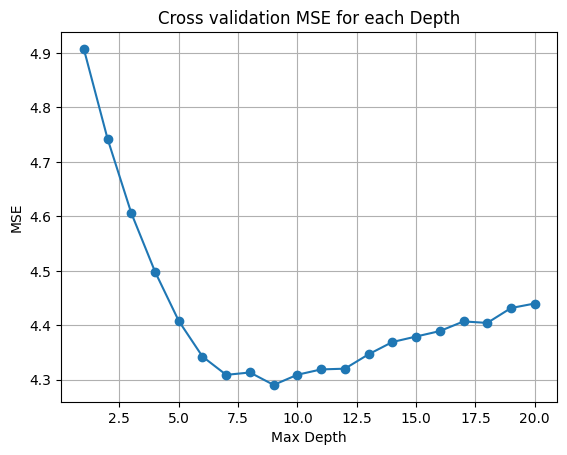

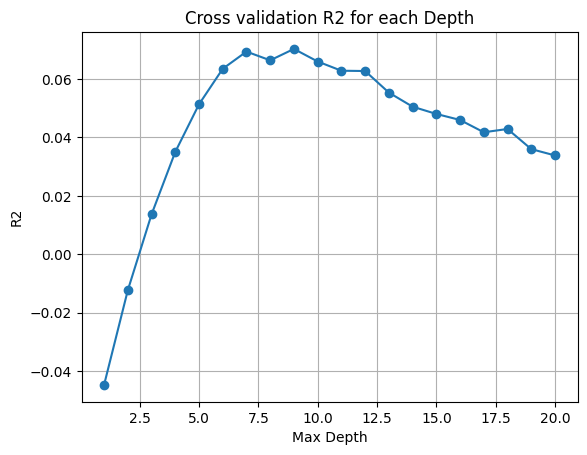

In [ ]:
# Determine what the max depth should be based
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

depths = range(1, 21)
mse_scores = []
r2_scores = []

for depth in depths:
    # Determine MSE for each depth
    model = RandomForestRegressor(max_depth=depth, n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', random_state=31)
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores.append(-scores.mean())
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    r2_scores.append(scores.mean())

plt.figure()
plt.plot(depths, mse_scores, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.title('Cross validation MSE for each Depth')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(depths, r2_scores, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('R2')
plt.title('Cross validation R2 for each Depth')
plt.grid(True)
plt.show()

# It appears 9 is the optimal depth, let's just round it up to 10

In [ ]:
# Determine optimal parameters

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

param_grid = {
    'max_depth': [10],
    'n_estimators': [100, 200],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5],
    'random_state': [31],
    'max_features': ['sqrt']
}

grid = GridSearchCV(RandomForestRegressor(random_state=31), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best R2 score:", grid.best_score_)
print("Test R2:", grid.score(X_test, y_test))

grid2 = GridSearchCV(RandomForestRegressor(random_state=31), param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid2.fit(X_train, y_train)
print("Best RMSE score:", -grid2.best_score_)
print("Test RMSE:", -grid2.score(X_test, y_test))

Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 31}
Best R2 score: 0.2252807991382409
Test R2: 0.23632090726655097
Best RMSE score: 1.9626067698367025
Test RMSE: 1.9352043766637064


In [ ]:
# Plot one of the trees
from sklearn import tree

fn=X.columns.to_list()
cn=y
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,10), dpi=800)
tree.plot_tree(grid.best_estimator_.estimators_[1],
               feature_names = fn,
               class_names=cn,
               filled = True);

In [ ]:
# Feature importance
from sklearn.inspection import permutation_importance

model = RandomForestRegressor(max_depth=10, n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', random_state=31)
model.fit(X_train, y_train)

importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=31)

In [ ]:
feature_names = X_train.columns

perm_df = pd.DataFrame({'feature': feature_names, 'importance': importance.importances_mean})
perm_df = perm_df.sort_values('importance', ascending=False)

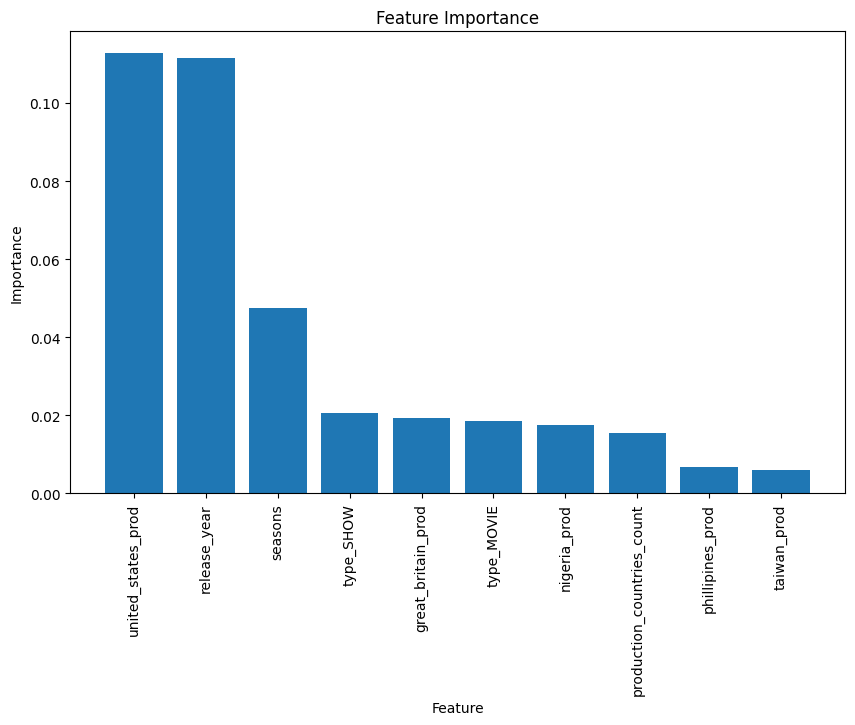

In [ ]:
# Print the top 10 important features
plt.figure(figsize=(10, 6))
plt.bar(perm_df.head(10)['feature'], perm_df.head(10)['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()